In [59]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense, LSTM, Reshape
from tensorflow.keras.regularizers import l2

# load data
data = pd.read_excel(os.path.join('..', 'data', 'raw', 'market_data.xlsx'), index_col='Date', usecols=['Date', 'PE', 'CPI', 'M2', '_MKT'])

# M2 CPI growth gap
data['M2_Growth'] = data['M2'].pct_change()
data['CPI_Growth'] = data['CPI'].pct_change()
data['M2_CPI_Growth_Comparison'] = np.where(data['M2_Growth'] > data['CPI_Growth'], 1, 0)  # 1 if M2 growth > CPI growth, else 0

# PE
data['PE_High_Low'] = np.where(data['PE'] > data['PE'].median(), 1, 0)  # 1 for high PE, 0 for low PE

# drop rows with NaN values after rolling
data = data.dropna()

# scale
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
scaled_data = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

scaled_data.to_csv(os.path.join('..', 'data', 'processed', 'scaled_feature_data.csv'), index='Data')

def create_lagged_dataset(data, lag):
    X, y = [], []
    for i in range(len(data) - lag):
        X.append(data.iloc[i:(i + lag)].values)
        y.append(data.iloc[i + lag]['_MKT'])
    return np.array(X), np.array(y)

# lagged dataset
lag = 4 # use prev 4 week data to predict (approx. 1 month)
X, y = create_lagged_dataset(scaled_data, lag=lag)

# time-based split (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# input shape
input_shape = (X.shape[1], X.shape[2])

In [60]:
# build
inputs = Input(shape=input_shape)
x = Conv1D(filters=16, kernel_size=2, activation='relu')(inputs)
x = Conv1D(filters=32, kernel_size=2, activation='relu')(x)
x = Conv1D(filters=64, kernel_size=2, activation='relu')(x)
x = Flatten()(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dense(16, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dense(8, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Reshape((8, 1))(x)
x = LSTM(50, return_sequences=True)(x)
x = LSTM(50)(x)
outputs = Dense(1)(x)

# compile
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mse')

# train
history = model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test), verbose=0)

# predict
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [61]:
# evaluate model
is_mse = mean_squared_error(y_train, train_predictions)
is_rmse = np.sqrt(is_mse)
is_mae = mean_absolute_error(y_train, train_predictions)
is_mape = mean_absolute_percentage_error(y_train, train_predictions)
is_r2 = r2_score(y_train, train_predictions)
os_mse = mean_squared_error(y_test, test_predictions)
os_rmse = np.sqrt(os_mse)
os_mae = mean_absolute_error(y_test, test_predictions)
os_mape = mean_absolute_percentage_error(y_test, test_predictions)
os_r2 = r2_score(y_test, test_predictions)

print(f'In-Sample MSE: {is_mse}')
print(f'Out-of-Sample MSE: {os_mse}')
print(f'In-Sample RMSE: {is_rmse}')
print(f'Out-of-Sample RMSE: {os_rmse}')
print(f'In-Sample MAE: {is_mae}')
print(f'Out-of-Sample MAE: {os_mae}')
print(f'In-Sample MAPE: {is_mape}')
print(f'Out-of-Sample MAPE: {os_mape}')
print(f'In-Sample R2: {is_r2}')
print(f'Out-of-Sample R2: {os_r2}')

In-Sample MSE: 3.8289404197435056e-05
Out-of-Sample MSE: 0.0033510705798466024
In-Sample RMSE: 0.00618784325895825
Out-of-Sample RMSE: 0.05788843217644266
In-Sample MAE: 0.00488620460314594
Out-of-Sample MAE: 0.04128369646470665
In-Sample MAPE: 30294111817.339985
Out-of-Sample MAPE: 0.05755830525151864
In-Sample R2: 0.99607065570492
Out-of-Sample R2: 0.8791722708611726


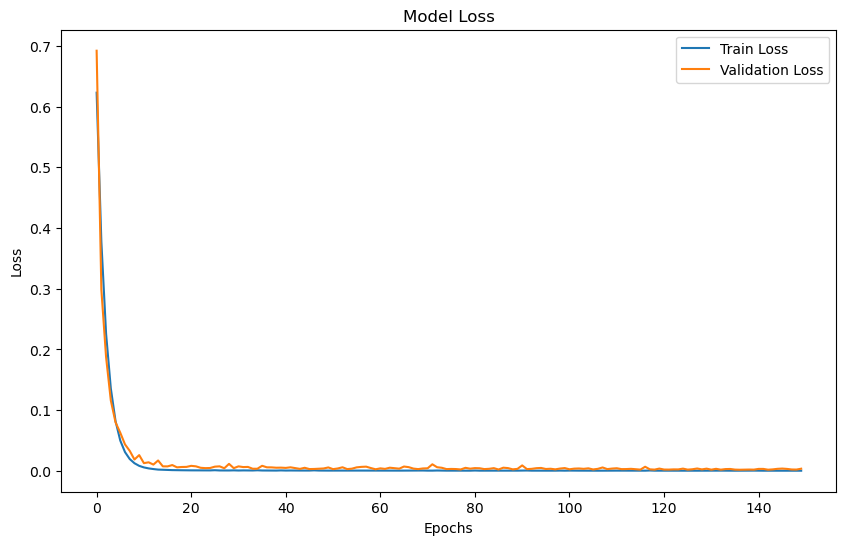

In [62]:
# training & validation loss values as fxn of epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

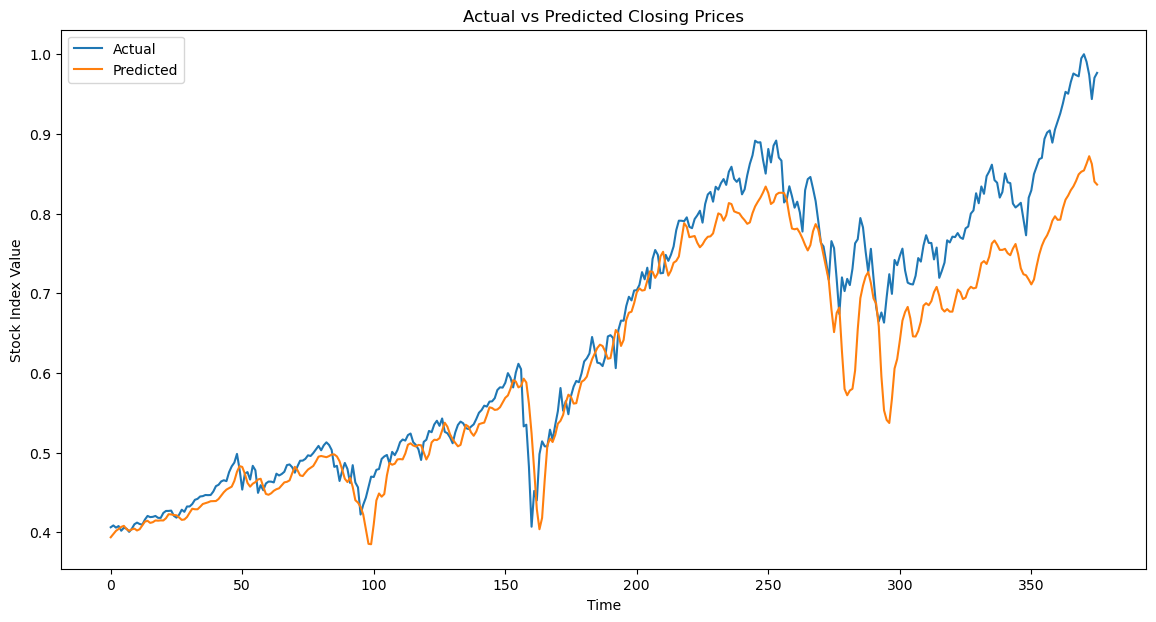

In [77]:
# actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual')
plt.plot(test_predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Index Value')
plt.title('Actual vs Predicted Closing Prices')
plt.legend()
plt.show()

In [83]:
def generate_additional_signals(data):
    m2_growth = data['M2'].pct_change()
    cpi_growth = data['CPI'].pct_change()
    pe_ratio = data['PE']

    # signal based on M2 and CPI gap
    gap_signal = np.where(m2_growth > cpi_growth, 1, -1)  # buy if M2 growth > CPI growth, sell otherwise
    
    # signal based on PE ratio
    pe_signal = np.where(pe_ratio > pe_ratio.mean(), -1, 1)  # sell if PE > mean PE, buy otherwise
    
    return gap_signal, pe_signal

gap_signal, pe_signal = generate_additional_signals(data)

gap_signal_train = gap_signal[1:train_size]
gap_signal_test = gap_signal[train_size+lag+1:]
pe_signal_train = pe_signal[-len(train_predictions):]
pe_signal_test = pe_signal[len(train_predictions)+lag:]

def calculate_pnl(signals, returns):
    return signals * returns  # PnL

# market returns
market_returns_train = data['_MKT'].iloc[:train_size].pct_change().dropna().values
market_returns_test = data['_MKT'].iloc[train_size+lag:].pct_change().dropna().values

train_pnl_gap = calculate_pnl(gap_signal_train, market_returns_train)
test_pnl_gap = calculate_pnl(gap_signal_test, market_returns_test)

# cumulative returns
train_cumulative_pnl = np.cumsum(train_pnl_gap)
test_cumulative_pnl = np.cumsum(test_pnl_gap)

# IR
def calculate_ir(pnl, market_returns):
    excess_returns = pnl - market_returns[:len(pnl)]
    return (np.mean(excess_returns) / np.std(excess_returns)) * np.sqrt(52)  # Annualized IR

train_ir = calculate_ir(train_pnl_gap, market_returns_train)
test_ir = calculate_ir(test_pnl_gap, market_returns_test)

print(f'In-Sample IR: {train_ir}')
print(f'Out-of-Sample IR: {test_ir}')

# underlying strategy returns
def calculate_buy_and_hold_returns(data, train_size, lag):
    bh_returns_train = data['_MKT'].iloc[:train_size].pct_change().dropna().values
    bh_returns_test = data['_MKT'].iloc[train_size+lag:].pct_change().dropna().values
    
    bh_cumulative_returns_train = np.cumsum(bh_returns_train)
    bh_cumulative_returns_test = np.cumsum(bh_returns_test)
    
    return bh_cumulative_returns_train, bh_cumulative_returns_test

bh_cumulative_returns_train, bh_cumulative_returns_test = calculate_buy_and_hold_returns(data, train_size, lag)


In-Sample IR: -0.7127098360608052
Out-of-Sample IR: -0.7433249448845426


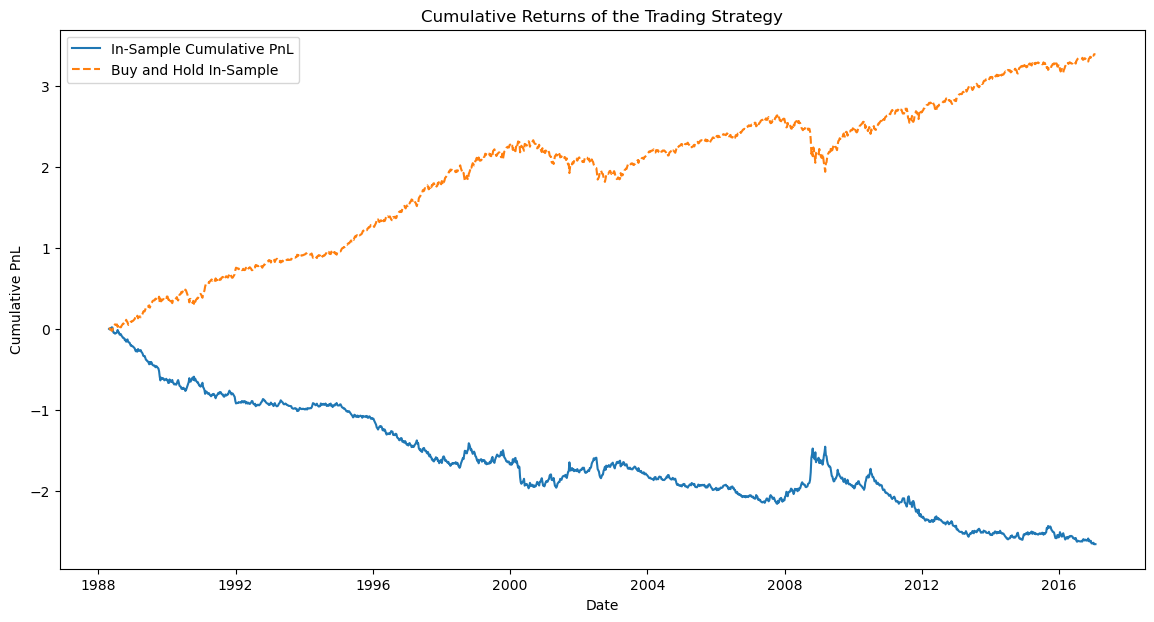

In [84]:
# plot
plt.figure(figsize=(14, 7))
plt.plot(data.index[:train_size][1:len(train_cumulative_pnl)+1], train_cumulative_pnl, label='In-Sample Cumulative PnL')
plt.plot(data.index[:train_size][1:len(bh_cumulative_returns_train)+1], bh_cumulative_returns_train, label='Buy and Hold In-Sample', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.title('Cumulative Returns of the Trading Strategy')
plt.legend()
plt.show()

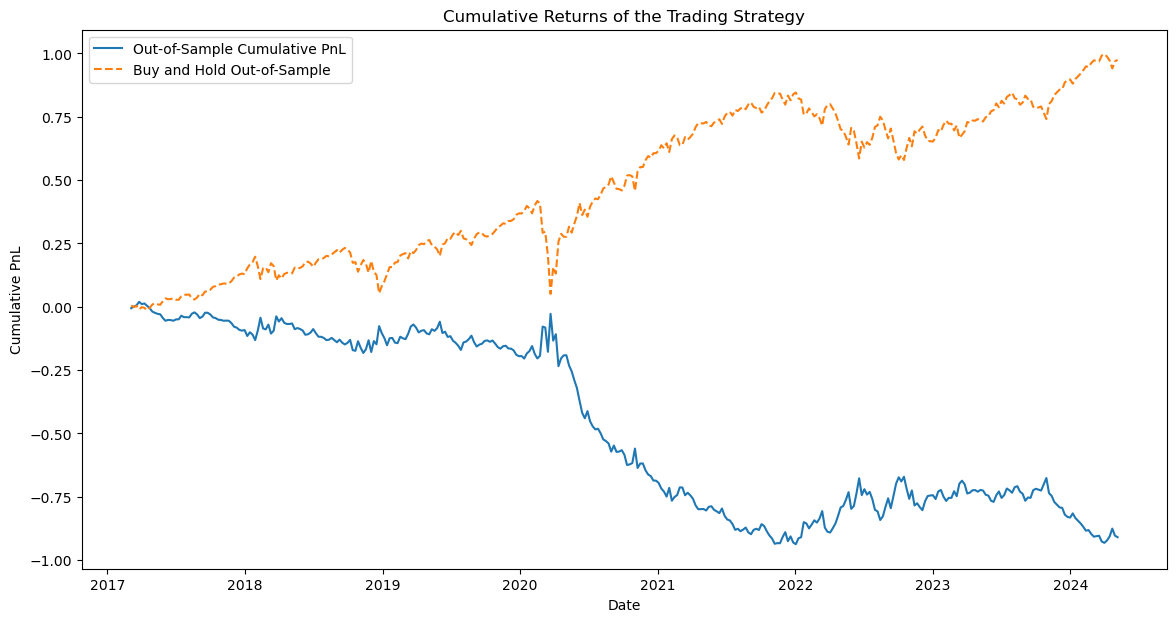

In [85]:
# Plot cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(data.index[train_size+lag:][1:len(test_cumulative_pnl)+1], test_cumulative_pnl, label='Out-of-Sample Cumulative PnL')
plt.plot(data.index[train_size+lag:][1:len(bh_cumulative_returns_test)+1], bh_cumulative_returns_test, label='Buy and Hold Out-of-Sample', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.title('Cumulative Returns of the Trading Strategy')
plt.legend()
plt.show()